# NTuple Analysis
Analyzes the data from a ntuple file

In [1]:
from boosted_lorenzetti.dataset import ntuple
from boosted_lorenzetti.utils import set_logger
import boosted_lorenzetti.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import ROOT
import logging
import numpy as np

/opt/conda/envs/dev/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ATLAS)
set_logger()
mpl.rc('text', usetex = True)

In [3]:
lzt_data = Path.home() / 'data' / 'lorenzetti'
output_dir = lzt_data / 'analysis' / 'joao-dataset-validation-2025-09-04'
output_dir.mkdir(exist_ok=True, parents=True)
datasets = {}
logging.info('Reading Zee')
datasets['zee'] = {
    'ntuple_pdf': ntuple.to_pdf(
        lzt_data /
        'v2.2.0' /
        'user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k' /
        'NTUPLE').query('abs(cl_eta) < 2.5'),
    'color': 'blue',
    'label': '$Z \\to ee$',
}

logging.info('Reading Zee with pileup')
datasets['zee_w_pileup'] = {
    'ntuple_pdf': ntuple.to_pdf(
        lzt_data /
        'v2.2.0' /
        'user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k.avgmu250_sigmamu50' /
        'NTUPLE').query('abs(cl_eta) < 2.5'),
    'color': 'red',
    'label': '$Z \\to ee + <\\mu>=250$',
}

datasets

2025-09-04 18:45:02 | INFO | root | 902614100 | 5 | Reading Zee
2025-09-04 18:45:50 | INFO | root | 902614100 | 16 | Reading Zee with pileup


{'zee': {'ntuple_pdf':         EventNumber  RunNumber  avgmu  cl_eta  cl_phi           cl_e  \
  2             88713     250520      0 -1.0625  2.7366   48573.324219   
  5             88766     250520      0  1.1625 -1.7548   28431.535156   
  6             88766     250520      0 -1.5255  1.1168   42405.429688   
  7             88767     250520      0 -0.0125 -1.9757   37224.570312   
  8             88767     250520      0  1.2875  1.0677   62649.765625   
  ...             ...        ...    ...     ...     ...            ...   
  123936        17541     250520      0  0.9375 -1.4358   49177.457031   
  123938        17548     250520      0 -2.2755  0.2086     156859.625   
  123939        17548     250520      0 -0.6125 -2.8348   35917.160156   
  123940        17567     250520      0  2.1255 -0.2331  129311.429688   
  123941        17584     250520      0  2.2505  1.0186      191488.25   
  
                 cl_et  cl_deta  cl_dphi       cl_e0  ...  el_loose  el_vloose  \
  2   

# Ring Size

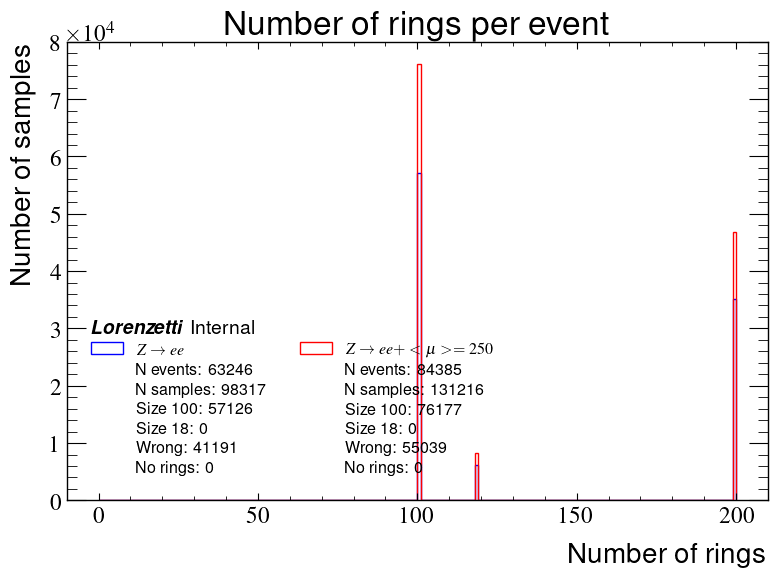

In [4]:
fig, ax = plt.subplots()
max_ring_size = -1
bins = np.arange(201)
for name, dataset_info in datasets.items():
    rings_size = dataset_info['ntuple_pdf']['cl_rings'].list.len()
    current_max_ring_size = rings_size.max()
    if current_max_ring_size > max_ring_size:
        max_ring_size = current_max_ring_size
    ax.hist(rings_size,
            bins=np.arange(current_max_ring_size + 1),
            histtype='step',
            color=dataset_info['color'],
            label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    ax.plot([], [], ' ',
        label=f'N events: {dataset_info["ntuple_pdf"]["EventNumber"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(dataset_info["ntuple_pdf"])}')
    has_100 = rings_size == 100
    ax.plot([], [], ' ',
            label=f'Size 100: {has_100.sum()}')
    has_18 = rings_size == 18
    ax.plot([], [], ' ',
            label=f'Size 18: {has_18.sum()}')
    ax.plot([], [], ' ',
            label=f'Wrong: {((~has_100) & (~has_18)).sum()}')
    ax.plot([], [], ' ',
            label=f'No rings: {(rings_size == 0).sum()}')
ax.set(
    xlabel='Number of rings',
    ylabel='Number of samples',
    title='Number of rings per event',
    xlim=(-10, max_ring_size + 10)
)
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          fontsize='small',
          loc='lower left'
          )
fig.tight_layout()
# fig.savefig(output_dir / f'number_of_rings_{data_src}.png', dpi=300)

# Cluster Energy

2025-09-04 18:47:18 | INFO | root | 1477752478 | 14 | Plotting dataset zee
2025-09-04 18:47:18 | INFO | root | 1477752478 | 14 | Plotting dataset zee_w_pileup


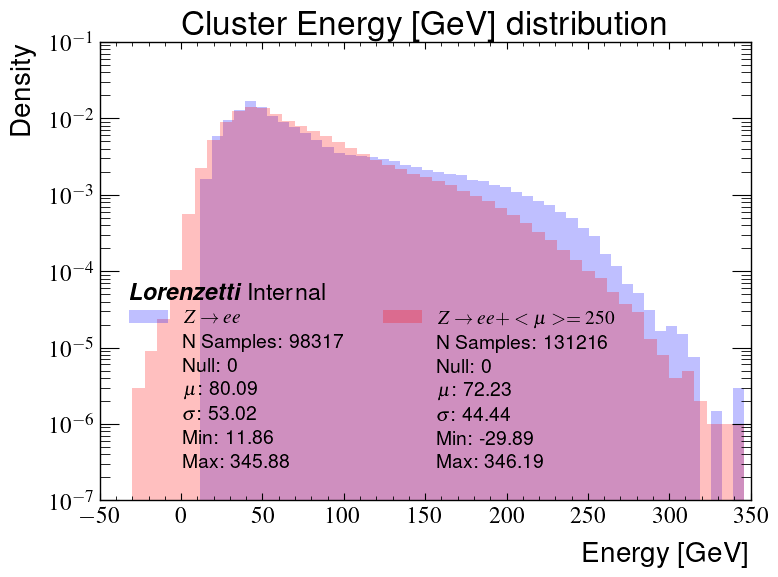

In [5]:
density = True
col_name = 'cl_e'
xlabel = 'Energy [GeV]'

if density:
    filename = 'cl_energy_distribution_density.png'
    ylabel = 'Density'
else:
    filename = 'cl_energy_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]/1000
    lplt.histplot(
        plotdata.dropna(),
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel=ylabel,
            title=f'Cluster {xlabel} distribution',
            yscale='log'
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {plotdata.isnull().sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large')
)
fig.tight_layout()
# fig.savefig(output_dir/filename, bbox_inches='tight', dpi=300)

# Cluster $E_T$

2025-09-04 18:47:18 | INFO | root | 2607454943 | 14 | Plotting dataset zee
2025-09-04 18:47:18 | INFO | root | 2607454943 | 14 | Plotting dataset zee_w_pileup


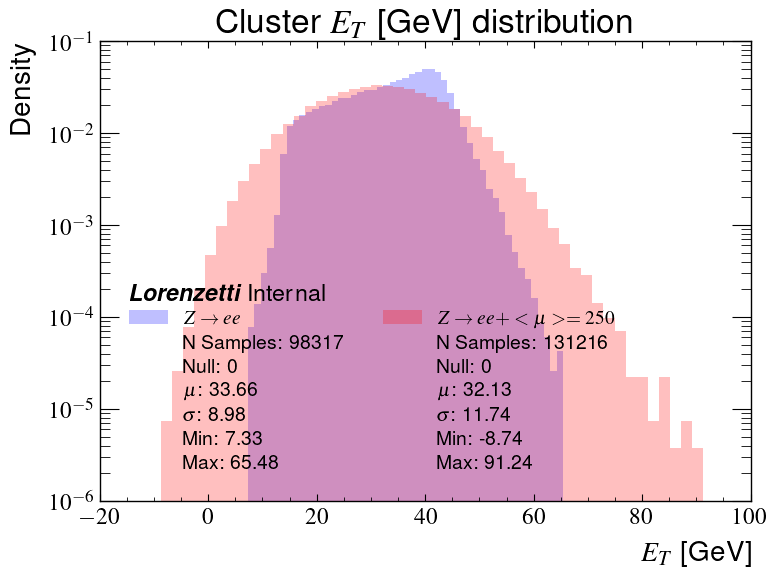

In [6]:
density = True
col_name = 'cl_et'
xlabel = '$E_T$ [GeV]'

if density:
    filename = 'cl_et_distribution_density.png'
    ylabel = 'Density'
else:
    filename = 'cl_et_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]/1000
    lplt.histplot(
        plotdata.dropna(),
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel=ylabel,
            title=f'Cluster {xlabel} distribution',
            yscale='log'
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {plotdata.isnull().sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large')
)
fig.tight_layout()
# fig.savefig(output_dir/filename, bbox_inches='tight', dpi=300)

# Cluster $\eta$

2025-09-04 18:47:19 | INFO | root | 3628691904 | 14 | Plotting dataset zee
2025-09-04 18:47:19 | INFO | root | 3628691904 | 14 | Plotting dataset zee_w_pileup


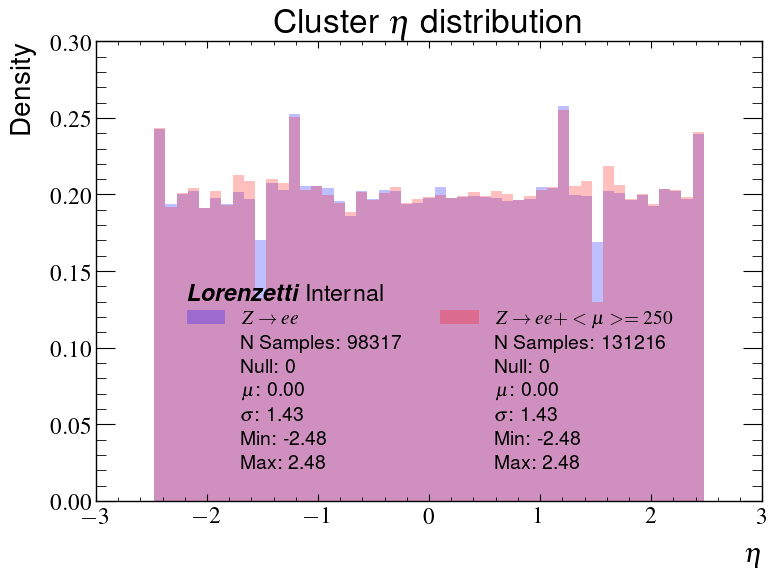

In [7]:
density = True
col_name = 'cl_eta'
xlabel = '$\\eta$'

if density:
    filename = 'cl_eta_distribution_density.png'
    ylabel = 'Density'
else:
    filename = 'cl_eta_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]
    lplt.histplot(
        plotdata.dropna(),
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel=ylabel,
            title=f'Cluster {xlabel} distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {plotdata.isnull().sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large')
)
fig.tight_layout()
# fig.savefig(output_dir/filename, bbox_inches='tight', dpi=300)

# Cluster $\phi$

2025-09-04 18:47:19 | INFO | root | 218144275 | 14 | Plotting dataset zee
2025-09-04 18:47:19 | INFO | root | 218144275 | 14 | Plotting dataset zee_w_pileup


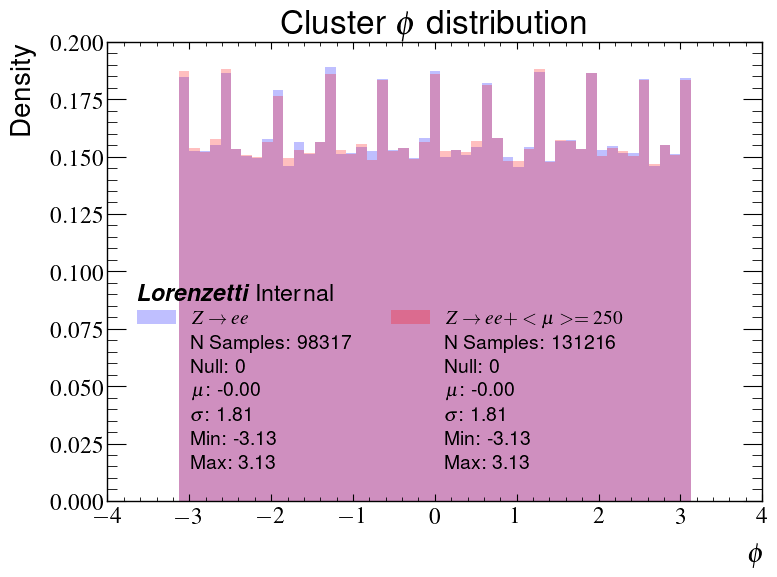

In [8]:
density = True
col_name = 'cl_phi'
xlabel = '$\\phi$'

if density:
    filename = 'cl_phi_distribution_density.png'
    ylabel = 'Density'
else:
    filename = 'cl_phi_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]
    lplt.histplot(
        plotdata.dropna(),
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel=ylabel,
            title=f'Cluster {xlabel} distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {plotdata.isnull().sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large')
)
fig.tight_layout()
# fig.savefig(output_dir/filename, bbox_inches='tight', dpi=300)

# Cluster $E_{ratio}$

2025-09-04 18:47:20 | INFO | root | 2734793637 | 14 | Plotting dataset zee
2025-09-04 18:47:20 | INFO | root | 2734793637 | 14 | Plotting dataset zee_w_pileup


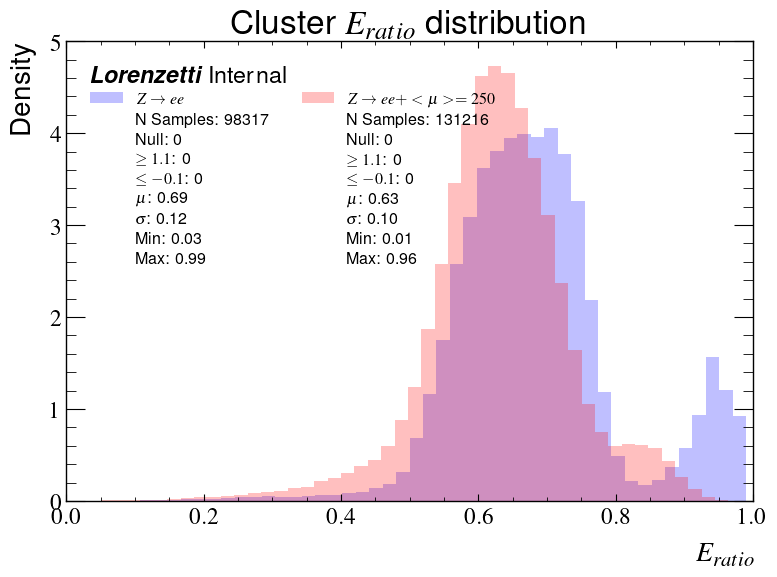

In [9]:
density = True
col_name = 'cl_eratio'
xlabel = '$E_{{ratio}}$'

if density:
    filename = 'cl_eratio_distribution_density.png'
    ylabel = 'Density'
else:
    filename = 'cl_eratio_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]
    over_limit = plotdata >= 1.1
    under_limit = plotdata <= -0.1
    is_null = plotdata.isnull()
    valid_samples = ~over_limit & ~under_limit & ~is_null
    valid_plotdata = plotdata[valid_samples]
    lplt.histplot(
        valid_plotdata,
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel=ylabel,
            title=f'Cluster {xlabel} distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {is_null.sum()}')
    ax.plot([], [], ' ', label=f'$\\geq 1.1$: {over_limit.sum()}')
    ax.plot([], [], ' ', label=f'$\\leq -0.1$: {under_limit.sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {valid_plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {valid_plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large'),
    fontsize='small',
    loc='upper left'
)

fig.tight_layout()
# fig.savefig(output_dir/filename, bbox_inches='tight', dpi=300)

In [ ]:
density = True
col_name = 'cl_eratio'
xlabel = '$E_{{ratio}}$'
eta_max = np.inf
eta_min = 2.5

if density:
    filename = f'cl_eratio__abs_cl_eta_min_{eta_min}_eta_max_{eta_max}_distribution_density.png'
    ylabel = 'Density'
else:
    filename = f'cl_eratio__abs_cl_eta_min_{eta_min}_eta_max_{eta_max}_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]
    abs_eta = dataset_info['ntuple_pdf']['cl_eta'].abs()
    in_eta_range = (abs_eta <= eta_max) & (abs_eta >= eta_min)
    plotdata = plotdata[in_eta_range]
    over_limit = plotdata >= 1.1
    under_limit = plotdata <= -0.1
    is_null = plotdata.isnull()
    valid_samples = ~over_limit & ~under_limit & ~is_null
    valid_plotdata = plotdata[valid_samples]
    lplt.histplot(
        valid_plotdata,
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel=ylabel,
            title=f'Cluster {xlabel} distribution',
            xlim=(0,1.1)
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    if eta_max == np.inf:
        str_eta_max = '\\infty'
        connector = '<'
    else:
        str_eta_max = str(eta_max)
        connector = '\\leq'
    ax.plot([], [], ' ', label=f'${eta_min} \\leq |\\eta| {connector} {str_eta_max}$')
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {is_null.sum()}')
    ax.plot([], [], ' ', label=f'$\\geq 1.1$: {over_limit.sum()}')
    ax.plot([], [], ' ', label=f'$\\leq -0.1$: {under_limit.sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {valid_plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {valid_plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title=('\\textbf{{\\textit{{Lorenzetti}}}} Internal'),
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large'),
    fontsize='small',
    loc='upper left'
)
fig.tight_layout()
# fig.savefig(output_dir/filename,
#             bbox_inches='tight', dpi=300)

## $\eta \times E_{ratio}$

2025-09-04 18:51:32 | INFO | root | 1103473701 | 7 | Plotting dataset zee
2025-09-04 18:51:32 | INFO | root | 1103473701 | 7 | Plotting dataset zee_w_pileup


/tmp/ipykernel_814000/1103473701.py:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  jgrid.figure.tight_layout()
/tmp/ipykernel_814000/1103473701.py:38: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  jgrid.figure.tight_layout()


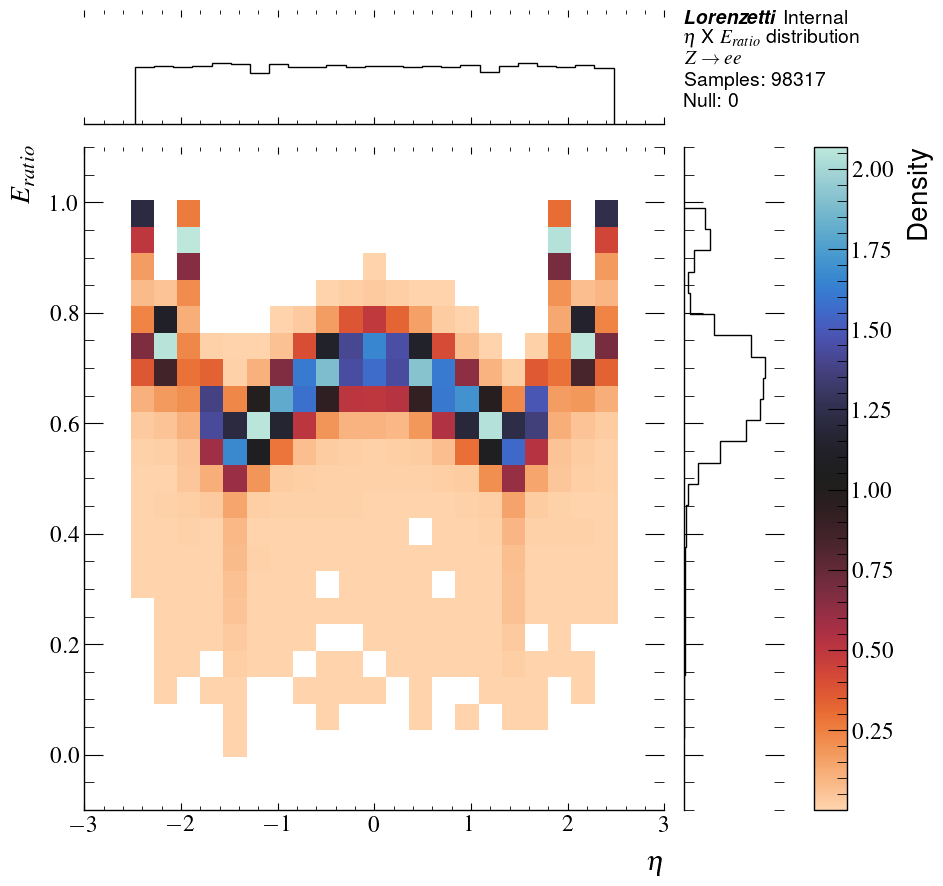

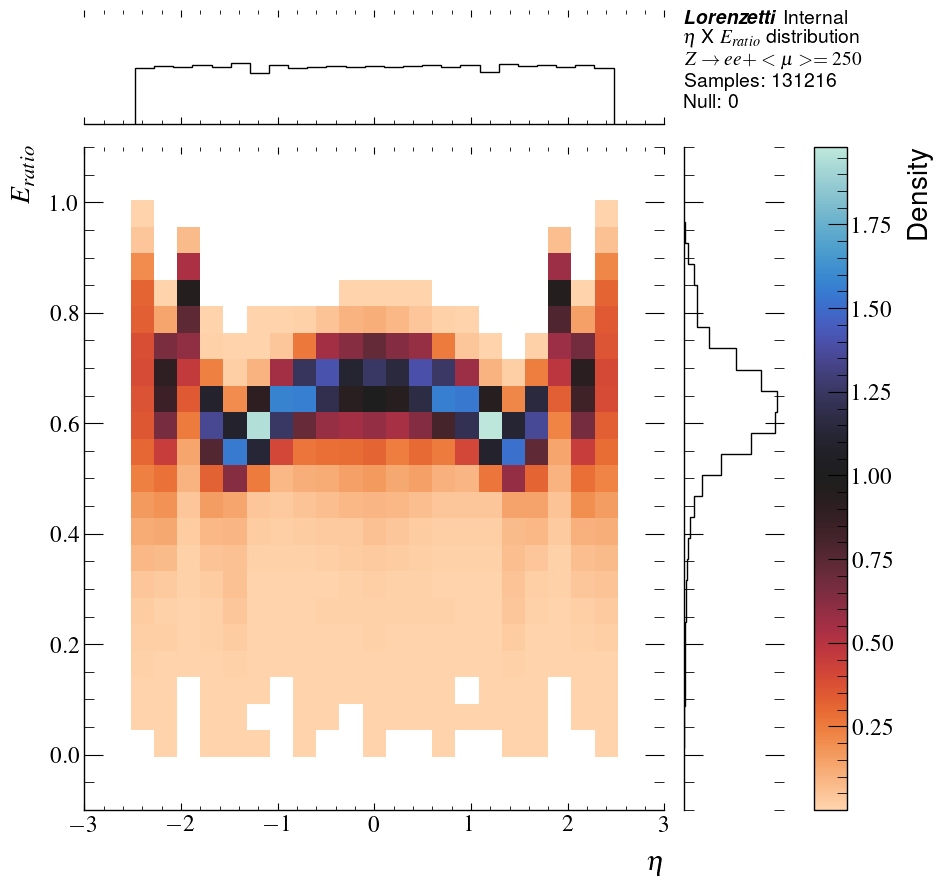

In [12]:
x_col = 'cl_eta'
xlabel = '$\\eta$'
y_col = 'cl_eratio'
ylabel = '$E_{{ratio}}$'

for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    over_limit = dataset_info['ntuple_pdf'][y_col] >= 1.1
    under_limit = dataset_info['ntuple_pdf'][y_col] <= -0.1
    is_null = dataset_info['ntuple_pdf'][y_col].isnull()
    valid_samples = ~over_limit & ~under_limit & ~is_null
    valid_plotdata = dataset_info['ntuple_pdf'].loc[valid_samples, [x_col, y_col]]
    corner_text = ('\\textbf{{\\textit{{Lorenzetti}}}} Internal\n'
                   f'{xlabel} X {ylabel} distribution\n'
                   f'{dataset_info["label"]}\n'
                   f'Samples: {len(valid_plotdata)}\n'
                   f'Null: {is_null.sum()}')
    jgrid, _ = lplt.hist2dplot(
        valid_plotdata,
        x=x_col,
        xlabel=xlabel,
        xaxis_hist_kwargs=dict(
            bins=25
        ),
        y=y_col,
        ylabel=ylabel,
        ylim=(-0.1, 1.1),
        yaxis_hist_kwargs=dict(
            bins=25
        ),
        joint_hist_kwargs=dict(
            cmap='icefire_r'
        ),
        norm='linear',
        corner_text=corner_text,
        figsize=(10, 10),
    )
    jgrid.figure.tight_layout()
    # jgrid.savefig(output_dir / f'{x_col}_{y_col}_{name}_distribution.png', bbox_inches='tight', dpi=300)

# Cluster $R_{had}$

2025-09-04 18:51:38 | INFO | root | 1708465435 | 14 | Plotting dataset zee


2025-09-04 18:51:38 | INFO | root | 1708465435 | 14 | Plotting dataset zee_w_pileup


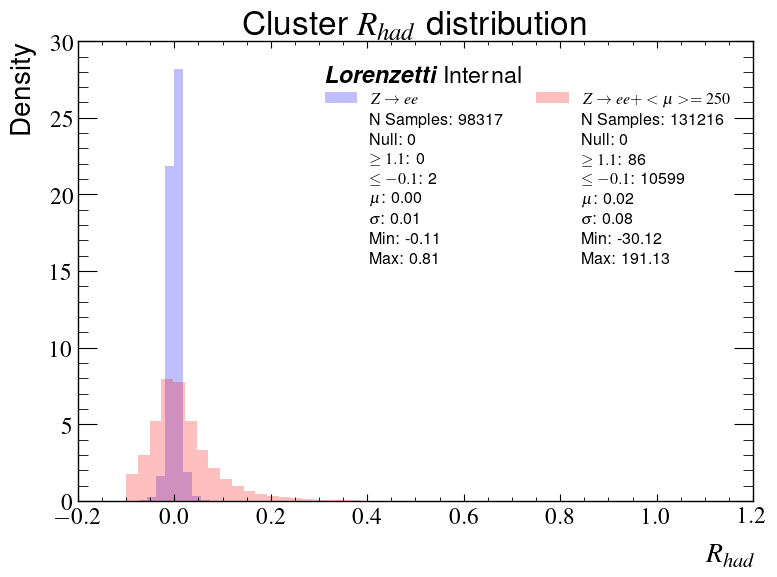

In [13]:
density = True
col_name = 'cl_rhad'
xlabel = '$R_{{had}}$'

if density:
    filename = 'cl_rhad_distribution_density.png'
    ylabel = 'Density'
else:
    filename = 'cl_rhad_distribution.png'
    ylabel = 'Counts'

fig, ax = plt.subplots()
for name, dataset_info in datasets.items():
    logging.info(f'Plotting dataset {name}')
    plotdata = dataset_info['ntuple_pdf'][col_name]
    over_limit = plotdata >= 1.1
    under_limit = plotdata <= -0.1
    is_null = plotdata.isnull()
    valid_samples = ~over_limit & ~under_limit & ~is_null
    valid_plotdata = plotdata[valid_samples]
    lplt.histplot(
        valid_plotdata,
        nbins=50,
        ax=ax,
        metrics=False,
        ax_set=dict(
            xlabel=xlabel,
            ylabel='Density' if density else 'Counts',
            title=f'Cluster {xlabel} distribution',
        ),
        hist_kwargs=dict(
            histtype='stepfilled',
            label=dataset_info['label'],
            color=dataset_info['color'],
            density=density,
            alpha=0.25
        )
    )
    ax.plot([], [], ' ', label=f'N Samples: {len(plotdata)}')
    ax.plot([], [], ' ', label=f'Null: {is_null.sum()}')
    ax.plot([], [], ' ', label=f'$\\geq 1.1$: {over_limit.sum()}')
    ax.plot([], [], ' ', label=f'$\\leq -0.1$: {under_limit.sum()}')
    ax.plot([], [], ' ', label=f'$\\mu$: {valid_plotdata.mean():.2f}')
    ax.plot([], [], ' ', label=f'$\\sigma$: {valid_plotdata.std():.2f}')
    ax.plot([], [], ' ', label=f'Min: {plotdata.min():.2f}')
    ax.plot([], [], ' ', label=f'Max: {plotdata.max():.2f}')
ax.legend(
    title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
    alignment='left',
    facecolor='white',
    ncols=len(datasets),
    title_fontproperties=dict(size='large'),
    fontsize='small'
)
fig.tight_layout()
# fig.savefig(output_dir/filename, bbox_inches='tight', dpi=300)